# Topic Modeling of Airport NOTAMs


In this notebook, we read the preprocessed NOTAMs data and identify differnt topics present in the messages. This exercise is based on the topic modeling analysis carried out on News data: https://github.com/emergent-analytics/workstreams/blob/master/ws2/news-analysis/%20ws2_2_topic_modelling.ipynb 

As the Qcodes present in the data also correspond to the nature of NOTAMs, we use topic modeling to ascertain our assumption

**Input**

  To generate the input dataset, refer this notebook: ws2_snr_NOTAMs_1_data_preparation
  
  Preprocessed airport dataset
  
  - valid_airport_notams_xx.csv

**Output**

Dataset with identified topics
  
  - valid_airport_notams_with_topics_xx.csv
  
Visualisation of topic modeling results
  
  
  - covid_airport_notams_lda.html

where 'xx' corresponds to the date


  
The following steps are carried out:

    1. Import the preprocessed data

    2. Filter out NOTAMs related to service hours 

    3. Train the LDA model and compute the coherence metric
    
    4. Visualize the topics
    
    5. LDA as feature
    
    6. Map manual labels to topics
    
    7. Analyse the results


In [ ]:
try:
    import spacy
except:
    !pip install spacy
try:
    import spacy_langdetect
except:
    !pip install spacy-langdetect
try:
    import flair
except:
    !pip install flair
try:
    import geonamescache
except:
    !pip install geonamescache
try:
    import spacy_fastlang
except:    
    !pip install spacy_fastlang
    #!pip install sense2vec==1.0.0a1
try:
    import gensim
except:
    !pip install gensim
try:
    import wordcloud
except:
    !pip install wordcloud
try:
    import nltk
except:
    !pip install nltk

try:
    import pyLDAvis
except:
    !pip install pyLDAvis

In [ ]:
import spacy

from collections import Counter, defaultdict

import pandas as pd
import os
import csv
import itertools
import re
import json
import numpy as np
import matplotlib.pyplot as plt
import datetime
import string

from spacy_langdetect import LanguageDetector
import plac
from spacy.lang.en import English
from spacy.matcher import PhraseMatcher
from spacy.tokens import Doc, Span, Token

from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.tokenize import regexp_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('tagsets')
nltk.download('words')

from wordcloud import WordCloud
from spacy import displacy
import seaborn as sbs
import geonamescache
import ast

#!pip install gensim
import gensim
from gensim import corpora
from gensim.models import CoherenceModel

#!pip install pyLDAvis
import pyLDAvis.gensim

plt.style.use('fivethirtyeight')
%matplotlib inline

**1. Import the preprocessed data**

In [4]:
apt_df_ = pd.read_csv("/project_data/data_asset/ws2/notams/valid_airport_notams_20200703.csv")

In [5]:
apt_df_.head()

,message,Qcode,createdDate,Closed,airportName,airportCode,cityName,countryCode,countryName,latitude,longitude,tokens,cleaned_message
0,RESIDENT CITIZENS OF MERCOSUR (TRAVELLING YOU...,FAXX,2020-06-11 19:47:00+00:00,False,Capitan Curbelo Intl,SULS,Maldonado,URY,Uruguay,-34.857222,-55.098056,"['resident', 'citizen', 'mercosur', 'travel', ...",resident citizens of mercosur travelling your ...
1,"PASSENGER, COMMERCIAL AND/OR PRIVATE FLT MAY ...",FAXX,2020-06-11 16:06:00+00:00,False,Capitan Curbelo Intl,SULS,Maldonado,URY,Uruguay,-34.857222,-55.098056,"['passenger', 'commercial', 'private', 'flight...",passenger commercial and or private flight may...
2,ALL INTL OPS ARE RESTRICTED TO SUMU AND SULS ...,FAXX,2020-06-11 15:39:00+00:00,False,Capitan Curbelo Intl,SULS,Maldonado,URY,Uruguay,-34.857222,-55.098056,"['international', 'operation', 'restrict', 'su...",all international operations are restricted to...
3,PURSUANT TO THE EMERG POWERS COVID19 NO2 ORDER...,XXAH,2020-05-07 16:41:00+00:00,False,Grand Bahama Intl,MYGF,Freeport,BHS,Bahamas,26.558686,-78.695553,"['pursuant', 'emergency', 'power', 'order', 'a...",pursuant to the emergency powers covid19 no2 o...
4,COVID-19: THE SERVICE LEVEL OF AIR TRAFFIC CON...,FAXX,2020-07-02 14:35:00+00:00,False,Turku,EFTU,Turku,FIN,Finland,60.514722,22.261667,"['covid', 'service', 'level', 'air', 'traffic'...",covid 19 the service level of air traffic cont...


**2. Filter out NOTAMs related to service hours**

Filtering out NOTAMs related to service hours and fire fighting rescue information

In [6]:
apt_lda_df = apt_df_[~((apt_df_.Qcode.str.endswith("AH")) | (apt_df_.Qcode == "FFCG"))]

In [7]:
apt_lda_df.reset_index(drop=True,inplace=True)

**3. Train the LDA model and compute the coherence metric**

In [8]:
words = []
for text in apt_lda_df['tokens']:
    words.append(ast.literal_eval(text))

In [9]:
len(words)

332

In [ ]:
# create the term dictionary of courpus
dictionary = corpora.Dictionary(words)

# filter the least and most frequent words: filters if less than no_below, more than no_above
dictionary.filter_extremes(no_below=10, no_above=0.9) 
dictionary.compactify()

# convert list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(word) for word in words]

In [ ]:
# train LDA, computing the coherence score for a range of topics
coherence_scores = []

for num_topics in range(2, 12, 1):
    
    print(f"Number of topics: ", num_topics)
    
    # create the object for LDA model using gensim library
    Lda = gensim.models.ldamulticore.LdaMulticore

    # run and train LDA model on the document term matrix.
    ldamodel = Lda(doc_term_matrix, 
                   num_topics=num_topics, 
                   id2word = dictionary, 
                   passes=20, 
                   chunksize = 2000, 
                   random_state=42,
                   workers=6)
    
    # compute the coherence score
    coherence_model = CoherenceModel(model=ldamodel, 
                                     texts=words, 
                                     dictionary=dictionary, 
                                     coherence='c_v')

    coherence_lda = coherence_model.get_coherence()
    
    coherence_scores.append((num_topics, coherence_lda))

coherence_scores = [*zip(*coherence_scores)]

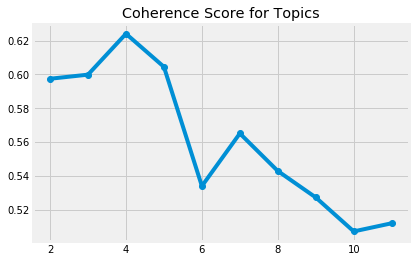

In [12]:
# plot the coherence score for topics
plt.plot(coherence_scores[0], coherence_scores[1], marker='o')
plt.title('Coherence Score for Topics')
plt.show()

As the above plot shows that there are 4 main topics in airport NOTAMs we assign the number of topics to 4

In [ ]:
# set the number of topics where coherence score is the highest
num_topics = 4

# run and train LDA model on the document term matrix.
Lda = gensim.models.ldamulticore.LdaMulticore

ldamodel = Lda(doc_term_matrix, 
               num_topics=num_topics, 
               id2word=dictionary, 
               passes=20, 
               chunksize=10000, 
               random_state=42,
               workers=6)

In [14]:
# view the topics with their most important words and their proportions
ldamodel.print_topics(num_topics=num_topics, num_words=10)

I0703 12:39:21.394510 140045383575360 ldamodel.py:1171] topic #0 (0.250): 0.052*"flight" + 0.039*"-PRON-" + 0.038*"passenger" + 0.033*"aircraft" + 0.026*"arrival" + 0.025*"prior" + 0.023*"require" + 0.022*"health" + 0.020*"crew" + 0.020*"airport"
I0703 12:39:21.396396 140045383575360 ldamodel.py:1171] topic #1 (0.250): 0.155*"flight" + 0.082*"control" + 0.054*"airport" + 0.053*"rule" + 0.051*"visual" + 0.045*"zone" + 0.039*"traffic" + 0.035*"air" + 0.028*"airspace" + 0.026*"international"
I0703 12:39:21.397918 140045383575360 ldamodel.py:1171] topic #2 (0.250): 0.207*"flight" + 0.038*"emergency" + 0.036*"cargo" + 0.034*"passenger" + 0.028*"international" + 0.023*"airport" + 0.020*"follow" + 0.020*"restriction" + 0.020*"close" + 0.019*"repatriation"
I0703 12:39:21.399220 140045383575360 ldamodel.py:1171] topic #3 (0.250): 0.072*"aerodrome" + 0.072*"service" + 0.071*"control" + 0.051*"information" + 0.048*"traffic" + 0.034*"air" + 0.030*"available" + 0.027*"hour" + 0.025*"area" + 0.024*"

[(0,
  '0.052*"flight" + 0.039*"-PRON-" + 0.038*"passenger" + 0.033*"aircraft" + 0.026*"arrival" + 0.025*"prior" + 0.023*"require" + 0.022*"health" + 0.020*"crew" + 0.020*"airport"'),
 (1,
  '0.155*"flight" + 0.082*"control" + 0.054*"airport" + 0.053*"rule" + 0.051*"visual" + 0.045*"zone" + 0.039*"traffic" + 0.035*"air" + 0.028*"airspace" + 0.026*"international"'),
 (2,
  '0.207*"flight" + 0.038*"emergency" + 0.036*"cargo" + 0.034*"passenger" + 0.028*"international" + 0.023*"airport" + 0.020*"follow" + 0.020*"restriction" + 0.020*"close" + 0.019*"repatriation"'),
 (3,
  '0.072*"aerodrome" + 0.072*"service" + 0.071*"control" + 0.051*"information" + 0.048*"traffic" + 0.034*"air" + 0.030*"available" + 0.027*"hour" + 0.025*"area" + 0.024*"aircraft"')]

**4. Visualize the topics**

In [ ]:
# visualize the intractive LDA plot
lda_display = pyLDAvis.gensim.prepare(ldamodel, 
                                      doc_term_matrix, 
                                      dictionary, 
                                      sort_topics=False)
pyLDAvis.display(lda_display)

In [16]:
# save the plot in html format
pyLDAvis.save_html(lda_display, f"/project_data/data_asset/ws2/notams/covid_airport_notams_lda.html")

**5. LDA as feature**

In [17]:
# user inputs
corpus = doc_term_matrix
texts = apt_lda_df
df = apt_lda_df

In [18]:
len(apt_lda_df),len(words)

(332, 332)

In [19]:
# function to get dominant topic, percentage of contribution, and keywords for each document
def format_topics_sentences(ldamodel, corpus):

    results = []
    
    # get main topic in each document
    for row in ldamodel[corpus]:
        
        if len(row) == 0:
            continue
            
        row = list(sorted(row, key=lambda elem: elem[1], reverse=True))
        
        # get the dominant topic, percentage of contribution and keywords for each document
        topic_num, prop_topic = row[0]        
        wp = ldamodel.show_topic(topic_num)
        topic_keywords = ", ".join([word for word, prop in wp])
        results.append((topic_num, round(prop_topic, 4), [topic_keywords]))
    
    df = pd.DataFrame.from_records(results, columns=['dominant_topic', 'weight', 'keywords'])
    
    return(df)

In [20]:
df_topics = format_topics_sentences(ldamodel, corpus)
df_topics.head()

,dominant_topic,weight,keywords
0,0,0.9299,"[flight, -PRON-, passenger, aircraft, arrival,..."
1,0,0.7683,"[flight, -PRON-, passenger, aircraft, arrival,..."
2,1,0.8745,"[flight, control, airport, rule, visual, zone,..."
3,3,0.9451,"[aerodrome, service, control, information, tra..."
4,3,0.9665,"[aerodrome, service, control, information, tra..."


In [21]:
len(df_topics)

332

In [28]:
# concatenate with the main dataset
apt_lda_df_ = pd.concat([apt_lda_df, df_topics.reindex(apt_lda_df.index)], axis=1)

**6. Map manual labels to topics**

In [30]:
# Define the topic labels for all the topics identified.
 
topics_dict = [[0, 'label_1'],
               [1, 'label_2'], 
               [2, 'label_3'], 
               [3, 'label_4']]

labels = pd.DataFrame(topics_dict, columns =['topic_num', 'topic_label'])

# merge with the main dataset
apt_lda_df_ = pd.merge(apt_lda_df_, labels, how='left', left_on = 'dominant_topic', right_on='topic_num')
apt_lda_df_.drop("topic_num", axis=1, inplace=True)
apt_lda_df_.head()

,message,Qcode,createdDate,Closed,airportName,airportCode,cityName,countryCode,countryName,latitude,longitude,tokens,cleaned_message,dominant_topic,weight,keywords,topic_label
0,RESIDENT CITIZENS OF MERCOSUR (TRAVELLING YOU...,FAXX,2020-06-11 19:47:00+00:00,False,Capitan Curbelo Intl,SULS,Maldonado,URY,Uruguay,-34.857222,-55.098056,"['resident', 'citizen', 'mercosur', 'travel', ...",resident citizens of mercosur travelling your ...,0,0.9299,"[flight, -PRON-, passenger, aircraft, arrival,...",label_1
1,"PASSENGER, COMMERCIAL AND/OR PRIVATE FLT MAY ...",FAXX,2020-06-11 16:06:00+00:00,False,Capitan Curbelo Intl,SULS,Maldonado,URY,Uruguay,-34.857222,-55.098056,"['passenger', 'commercial', 'private', 'flight...",passenger commercial and or private flight may...,0,0.7683,"[flight, -PRON-, passenger, aircraft, arrival,...",label_1
2,ALL INTL OPS ARE RESTRICTED TO SUMU AND SULS ...,FAXX,2020-06-11 15:39:00+00:00,False,Capitan Curbelo Intl,SULS,Maldonado,URY,Uruguay,-34.857222,-55.098056,"['international', 'operation', 'restrict', 'su...",all international operations are restricted to...,1,0.8745,"[flight, control, airport, rule, visual, zone,...",label_2
3,COVID-19: THE SERVICE LEVEL OF AIR TRAFFIC CON...,FAXX,2020-07-02 14:35:00+00:00,False,Turku,EFTU,Turku,FIN,Finland,60.514722,22.261667,"['covid', 'service', 'level', 'air', 'traffic'...",covid 19 the service level of air traffic cont...,3,0.9451,"[aerodrome, service, control, information, tra...",label_4
4,COVID 19 INFORMATION: NORWICH CTA/CTR ACTIVE A...,AECA,2020-06-24 15:06:00+00:00,False,Norwich,EGSH,Norwich,GBR,UK,52.675833,1.282778,"['covid', 'information', 'norwich', 'control',...",covid 19 information norwich control area cont...,3,0.9665,"[aerodrome, service, control, information, tra...",label_4


In [32]:
apt_lda_df_.to_csv("/project_data/data_asset/ws2/notams/valid_airport_notams_with_topics_20200703.csv", index=False, quoting=csv.QUOTE_NONNUMERIC)

**7. Analyse results**

In [41]:
for l in ["label_1","label_2","label_3","label_4"]:
    d_ = apt_lda_df_[apt_lda_df_.topic_label==l]
    print(l)
    print(len(d_))
    print(d_.Qcode.value_counts()[:5])
    #print(d_.countryName.unique())
    print(d_.keywords.values[0])

label_1
119
FAXX    49
XXXX    35
FALT    15
AFXX     4
FAAP     3
Name: Qcode, dtype: int64
['flight, -PRON-, passenger, aircraft, arrival, prior, require, health, crew, airport']
label_2
23
ACXX    16
FAXX     2
XXXX     1
ACCH     1
FULT     1
Name: Qcode, dtype: int64
['flight, control, airport, rule, visual, zone, traffic, air, airspace, international']
label_3
79
FALC    22
FALT    18
FAXX    16
XXXX    11
FAAP     3
Name: Qcode, dtype: int64
['flight, emergency, cargo, passenger, international, airport, follow, restriction, close, repatriation']
label_4
111
FAXX    25
FALT    10
FFCH     5
AEXX     5
SPXX     5
Name: Qcode, dtype: int64
['aerodrome, service, control, information, traffic, air, available, hour, area, aircraft']


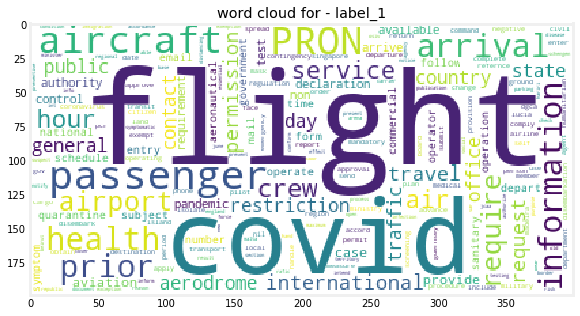

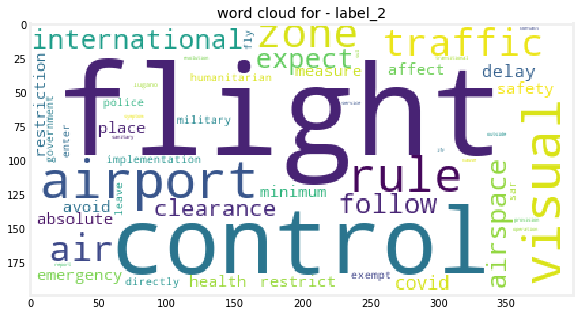

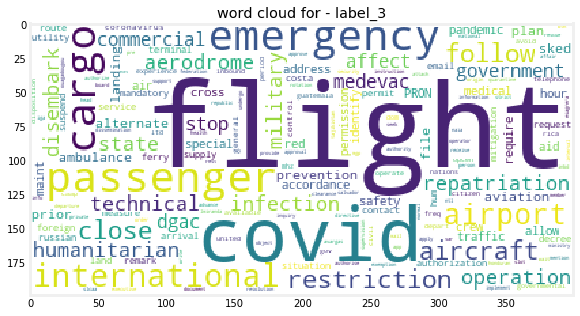

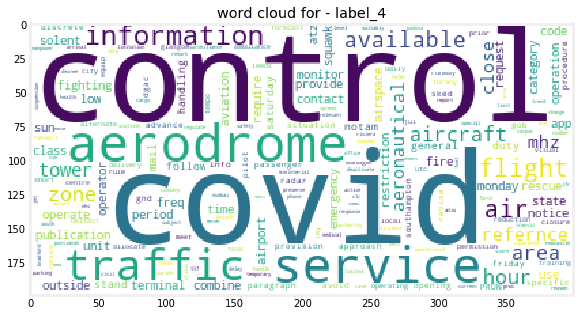

In [34]:
for label_ in ['label_1','label_2','label_3','label_4']:
    all_t = []
    for t in apt_lda_df_[apt_lda_df_.topic_label==label_]['tokens']:
        for t_ in ast.literal_eval(t):
            all_t.append(t_)

    wc = WordCloud(background_color="white", max_words=200, random_state=1,collocations=False).generate(' '.join(all_t))# to recolour the image
    plt.figure(figsize=(15,5)) #, width=1400, height=800,
    plt.title("word cloud for - {}".format(label_))
    plt.grid(b=None)
    plt.imshow(wc)

**Observations:**

Based on pyLDAvis and wordcloud of the different topics the following insights have been noted:

1. Label 3 contains information related to cargo

2. Labels 1 and 3 contain all the information related to quarantine

3. Label 2 contains information related to visual flight rules

4. Label 4 contains information more related to control tower as the terms in this label include tower, control, frequency, mhz (unit of frequency)


In terms of commercial passenger flights, topics with labels 1 and 3 are to be considered for further analysis

**Author**

* Shri Nishanth Rajendran - AI Development Specialist, R² Data Labs, Rolls Royce

The topic modelling work is based on the analysis done below:
https://github.com/emergent-analytics/workstreams/blob/master/ws2/news-analysis/%20ws2_2_topic_modelling.ipynb 